In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import sqlite3 as sql
import pandas as pd

In [2]:
DB_FILE = "data/database.sqlite"

In [3]:
db_conn = sql.connect(DB_FILE)

In [4]:
cursor = db_conn.execute("SELECT * FROM Player LIMIT 10")
for row in cursor:
    print(row)

(1, 505942, 'Aaron Appindangoye', 218353, '1992-02-29 00:00:00', 182.88, 187)
(2, 155782, 'Aaron Cresswell', 189615, '1989-12-15 00:00:00', 170.18, 146)
(3, 162549, 'Aaron Doran', 186170, '1991-05-13 00:00:00', 170.18, 163)
(4, 30572, 'Aaron Galindo', 140161, '1982-05-08 00:00:00', 182.88, 198)
(5, 23780, 'Aaron Hughes', 17725, '1979-11-08 00:00:00', 182.88, 154)
(6, 27316, 'Aaron Hunt', 158138, '1986-09-04 00:00:00', 182.88, 161)
(7, 564793, 'Aaron Kuhl', 221280, '1996-01-30 00:00:00', 172.72, 146)
(8, 30895, 'Aaron Lennon', 152747, '1987-04-16 00:00:00', 165.1, 139)
(9, 528212, 'Aaron Lennox', 206592, '1993-02-19 00:00:00', 190.5, 181)
(10, 101042, 'Aaron Meijers', 188621, '1987-10-28 00:00:00', 175.26, 170)


In [5]:
cursor = db_conn.execute("SELECT date FROM Match ORDER BY date LIMIT 10 ")
for row in cursor:
    print(row)

('2008-07-18 00:00:00',)
('2008-07-19 00:00:00',)
('2008-07-20 00:00:00',)
('2008-07-20 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-23 00:00:00',)
('2008-07-24 00:00:00',)
('2008-07-24 00:00:00',)
('2008-07-26 00:00:00',)


In [6]:
cursor = db_conn.execute("SELECT * FROM Country")
for row in cursor:
    print(row)

(1, 'Belgium')
(1729, 'England')
(4769, 'France')
(7809, 'Germany')
(10257, 'Italy')
(13274, 'Netherlands')
(15722, 'Poland')
(17642, 'Portugal')
(19694, 'Scotland')
(21518, 'Spain')
(24558, 'Switzerland')


In [7]:
cursor = db_conn.execute("SELECT * FROM League")
for row in cursor:
    print(row)

(1, 1, 'Belgium Jupiler League')
(1729, 1729, 'England Premier League')
(4769, 4769, 'France Ligue 1')
(7809, 7809, 'Germany 1. Bundesliga')
(10257, 10257, 'Italy Serie A')
(13274, 13274, 'Netherlands Eredivisie')
(15722, 15722, 'Poland Ekstraklasa')
(17642, 17642, 'Portugal Liga ZON Sagres')
(19694, 19694, 'Scotland Premier League')
(21518, 21518, 'Spain LIGA BBVA')
(24558, 24558, 'Switzerland Super League')


In [8]:
# classes for data objects
match_columns = "id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal"
betting_sources = ["B365","BW","IW","LB","PS","WH","SJ","VC","GB","BS"]
outcomes = ["H","D","A"]
for b in betting_sources:
    for o in outcomes:
        match_columns += "," + b + o

team_columns = "id,team_api_id,team_fifa_api_id,team_long_name,team_short_name"

def create_lookup(column_names, delim=","):
    return {c: i for (i,c) in enumerate(column_names.split(delim))}

match_column_lookup = create_lookup(match_columns)
team_column_lookup = create_lookup(team_columns)
all_match_ids = []
all_matches = {}
all_teams = {}

class MatchResult:
    HOME = 0
    DRAW = 1
    AWAY = 2
    
    def toStr(mr):
        if mr == MatchResult.HOME:
            return "HOME"
        elif mr == MatchResult.DRAW:
            return "DRAW"
        elif mr == MatchResult.AWAY:
            return "AWAY"
        else:
            return "UNKNOWN RESULT"

class Match(object):
    def __init__(self, rawData):
        # set attributes
        for col_name in match_column_lookup:
            setattr(self, col_name, rawData[match_column_lookup[col_name]])
            
        self.best_home_odds = self.best_draw_odds = self.best_away_odds = 0
        if self.home_team_goal > self.away_team_goal:
            self.match_result = MatchResult.HOME
        elif self.home_team_goal == self.away_team_goal:
            self.match_result = MatchResult.DRAW
        else:
            self.match_result = MatchResult.AWAY

class Team(object):
    def __init__(self, rawData):
        # set attributes
        for col_name in team_column_lookup:
            setattr(self, col_name, rawData[team_column_lookup[col_name]])        
        self.home_wins = self.home_draws = self.home_losses = 0
        self.away_wins = self.away_draws = self.away_losses = 0       
        self.home_win_percentage = self.home_draw_percentage = self.home_loss_percentage = 0
        self.away_win_percentage = self.away_draw_percentage = self.away_loss_percentage = 0
    
    @property
    def features(self):
        return [self.home_win_percentage, self.away_win_percentage, 
               self.home_draw_percentage, self.away_draw_percentage,
               self.home_loss_percentage, self.away_loss_percentage]

def compute_win_percentages(matches):
    # compute win percentage
    for match in matches.values():
        if match.match_result == MatchResult.HOME:
            all_teams[match.home_team_api_id].home_wins += 1
            all_teams[match.away_team_api_id].away_losses += 1
        elif match.match_result == MatchResult.DRAW:
            all_teams[match.home_team_api_id].home_draws += 1
            all_teams[match.away_team_api_id].away_draws += 1
        else:
            all_teams[match.home_team_api_id].home_losses += 1
            all_teams[match.away_team_api_id].away_wins += 1

    for team in all_teams.values():
        total_home_games = float(team.home_wins + team.home_draws + team.home_losses)
        if total_home_games > 0:
            team.home_win_percentage = team.home_wins / total_home_games
            team.home_draw_percentage = team.home_draws / total_home_games
            team.home_loss_percentage = team.home_losses / total_home_games
        total_away_games = float(team.away_wins + team.away_draws + team.away_losses)
        if total_away_games > 0:
            team.away_win_percentage = team.away_wins / total_away_games
            team.away_draw_percentage = team.away_draws / total_away_games
            team.away_loss_percentage = team.away_losses / total_away_games
            
def compute_best_odds(matches):
    for match in matches.values():
        odds = {o: [getattr(match, source + o) for source in betting_sources 
                if getattr(match, source + o) is not None] for o in outcomes }
        match.best_home_odds = max(odds[outcomes[0]]) if len(odds[outcomes[0]]) > 0 else 1
        match.best_draw_odds = max(odds[outcomes[1]]) if len(odds[outcomes[1]]) > 0 else 1
        match.best_away_odds = max(odds[outcomes[2]]) if len(odds[outcomes[2]]) > 0 else 1
        
        # TODO: compute corresponding implied odds

In [9]:
# load all matches
# only EPL for now
cursor = db_conn.execute("SELECT %s FROM Match ORDER BY date" % (match_columns))
for row in cursor:
    mid = row[match_column_lookup['match_api_id']]
    all_match_ids.append(mid)
    all_matches[mid] = Match(row)

In [10]:
# load all teams
cursor = db_conn.execute("SELECT %s FROM Team" % (team_columns))
for row in cursor:
    all_teams[row[team_column_lookup['team_api_id']]] = Team(row)

In [11]:
# input: match, object of class Match
# output: vector of real-valued features, vector of associated labels
def compute_match_features(match, one_hot=False):
    # [home_team_win_percentage,home_team_draw_percentage,home_team_loss_percentage,...
    #  away_team_win_percentage,away_team_draw_percentage,away_team_loss_percentage]
    # TODO: historical matchup percentages
    # TODO: fifa player ratings
    # TODO: fifa team attributes
    home_team = all_teams[match.home_team_api_id]
    away_team = all_teams[match.away_team_api_id]
    features = home_team.features + away_team.features
    
    if one_hot:
        label = [0 for _ in range(3)]
        label[match.match_result] = 1
        return (features, label)
    else:
        return (features, match.match_result)

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree, metrics

In [13]:
# create training/testing data sets
PROPORTION_TRAIN = 0.9

num_matches = len(all_matches)
num_train = int(PROPORTION_TRAIN * num_matches)

training_match_ids = all_match_ids[:num_train]
testing_match_ids = all_match_ids[num_train:]

# only compute statistics using training data
compute_win_percentages({mid:all_matches[mid] for mid in training_match_ids})
compute_best_odds(all_matches)

Ajax 0.7622950819672131
Manchester United 0.781021897810219
Chelsea 0.708029197080292
SL Benfica 0.8198198198198198
FC Porto 0.8454545454545455
Real Madrid CF 0.8455882352941176
FC Bayern Munich 0.7967479674796748
Celtic 0.7971014492753623
FC Basel 0.7251908396946565
Termalica Bruk-Bet Nieciecza 0.75
Manchester City 0.7591240875912408
Rangers 0.7368421052631579
FC Barcelona 0.8676470588235294
RSC Anderlecht 0.75
PSV 0.7786885245901639


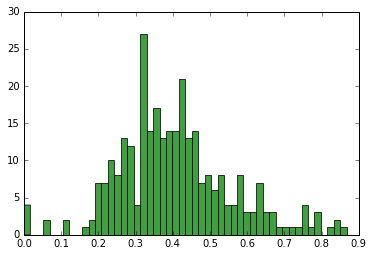

In [14]:
win_percentages = [team.home_win_percentage for team in all_teams.values()]
plt.hist(win_percentages, 50, facecolor='green', alpha=0.75)

for team in all_teams.values():
    if team.home_win_percentage > 0.7:
        print(team.team_long_name, team.home_win_percentage)

In [15]:
class BettingAlgorithm():
    def __init__(self):
        pass
    
    def train(self, matches):
        pass
    
    def form_bets(self, matches):
        pass

def compute_features_from_raw_data(matches, one_hot=False):
    X = []
    y = []
    for match in matches:
        (f,l) = compute_match_features(match, one_hot=one_hot)
        X.append(f)
        y.append(l)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.uint8)
    return (X, y)

def get_odds(bet):
    if bet[2] == MatchResult.HOME:
        return all_matches[bet[0]].best_home_odds
    elif bet[2] == MatchResult.DRAW:
        return all_matches[bet[0]].best_draw_odds
    else:
        return all_matches[bet[0]].best_away_odds

# bet : (mid, amount, winner)
def calculate_win_loss(b):
    m = all_matches[b[0]]
    odds = get_odds(b)
    if odds == 1.:
        return 0
    elif m.match_result == MatchResult.HOME and b[2] == MatchResult.HOME:
        return b[1] * (odds - 1)
    elif m.match_result == MatchResult.DRAW and b[2] == MatchResult.DRAW:
        return b[1] * (odds - 1)
    elif m.match_result == MatchResult.AWAY and b[2] == MatchResult.AWAY:
        return b[1] * (odds - 1)
    else:
        return -b[1]

def compute_pnl(bets):
    return sum([calculate_win_loss(b) for b in bets])

In [16]:
# naive predictor that always picks favorite
class NaiveAlgorithm(BettingAlgorithm):
    def __init__(self, **kwargs):
        super(NaiveAlgorithm, self).__init__()
    
    def train(self, matches):
        pass
        
    def form_bets(self, matches):
        matches = list(matches)
        bets = []
        for m in matches:
            if m.best_home_odds > 1 and m.best_draw_odds > 1 and m.best_away_odds > 1:
                ind = np.argmin([m.best_home_odds, m.best_draw_odds, m.best_away_odds])
                bets.append((m.match_api_id, 1., ind))
        return bets

In [17]:
# random forest predictor
class RandomForestAlgorithm(BettingAlgorithm):
    def __init__(self, **kwargs):
        super(RandomForestAlgorithm, self).__init__()
        self.classifier = RandomForestClassifier(**kwargs)
    
    def train(self, matches):
        X, y = compute_features_from_raw_data(matches)
        self.classifier = self.classifier.fit(X, y)
        
    def form_bets(self, matches):
        matches = list(matches)
        X, y = compute_features_from_raw_data(matches)
        predicted_labels = self.classifier.predict(X)
        print(sum([1 if y_true==y_pred else 0 for (y_true,y_pred) in zip(y,predicted_labels)])/float(len(y)))
        # juts bet $1 on every thing
        return [(m.match_api_id, 1., outcome) for (m,outcome) in zip(matches,predicted_labels)]

In [26]:
# neural net algorithm
import tensorflow as tf
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0., shape=shape)
  return tf.Variable(initial)

class NeuralNetAlgorithm(BettingAlgorithm):
    def __init__(self, **kwargs):
        super(NeuralNetAlgorithm, self).__init__()
        self.num_classes = 3
        self.sess = tf.InteractiveSession()
    
    def train(self, matches):
        self.X, self.y = compute_features_from_raw_data(matches, one_hot=True)
        self.index_in_epoch = 0
        self.num_examples = self.X.shape[0]
        self.num_features = self.X.shape[1]
        
        # form model
        self.x = tf.placeholder(tf.float32, shape=[None, self.num_features])
        self.y_ = tf.placeholder(tf.float32, shape=[None, self.num_classes])

        # layer 1
        self.hidden_layer_size = 50
        self.W1 = weight_variable([self.num_features, self.hidden_layer_size]) 
        self.b1 = bias_variable([self.hidden_layer_size])
        self.h1 = tf.nn.relu(tf.matmul(self.x, self.W1) + self.b1)
        
        # layer 2
        self.W2 = weight_variable([self.hidden_layer_size, self.num_classes]) 
        self.b2 = bias_variable([self.num_classes]) 
        
        # dropout
        self.keep_prob = tf.placeholder(tf.float32)
        self.y_dropped = tf.nn.dropout(self.h1, self.keep_prob)
        
        # softmax
        self.y_pred = tf.nn.softmax(tf.matmul(self.y_dropped, self.W2) + self.b2)
        
        self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y_pred), reduction_indices=[1]))
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)

        self.correct_prediction = tf.equal(tf.argmax(self.y_pred,1), tf.argmax(self.y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # actual train
        self.sess.run(tf.initialize_all_variables())
        for i in range(5000):
            batch = self.next_batch(100)
            if i % 500 == 0:
                train_accuracy = self.accuracy.eval(feed_dict={ self.x: batch[0], self.y_: batch[1], self.keep_prob: 1.0 })
                print("step %d: training accuracy %g" % (i, train_accuracy))
            self.train_step.run(feed_dict={ self.x: batch[0], self.y_: batch[1], self.keep_prob: 0.5 })
    
    def form_bets(self, matches):
        matches = list(matches)
        X, y = compute_features_from_raw_data(matches, one_hot=True)
        acc = self.accuracy.eval(feed_dict={ self.x: X, self.y_: y, self.keep_prob: 1.0 })
        print(acc)
        predictions = self.y_pred.eval(feed_dict={ self.x: X, self.y_: y, self.keep_prob: 1.0 })
        
        # only make bet if has highish confidence
        bets = []
        for (m,probs) in zip(matches,predictions):
            if max(probs) > 0.7:
                predicted_result = np.argmax(probs)
                # just bet $1 on everything for now
                bets.append((m.match_api_id, 1., predicted_result, probs))
        return bets
    
    # serve data by batches
    def next_batch(self, batch_size):
        start = self.index_in_epoch
        self.index_in_epoch += batch_size

        # when all trainig data have been already used, it is reorder randomly    
        if self.index_in_epoch > self.num_examples:
            # shuffle the data
            perm = np.arange(self.num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.y = self.y[perm]
            # start next epoch
            start = 0
            self.index_in_epoch = batch_size
        end = self.index_in_epoch
        return self.X[start:end], self.y[start:end]

In [27]:
# test and evaluate Naive Algo
naive_algo = NaiveAlgorithm()

# train (naive doesn't train)

# evaluate
testing_bets = naive_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(testing_bets)

-70.60000000000016

In [28]:
# test and evaluate Random Forest Algo
rf_algo = RandomForestAlgorithm(n_estimators = 20)

# train
rf_algo.train([all_matches[mid] for mid in training_match_ids])

# evaluate
testing_bets = rf_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(testing_bets)

0.4353348729792148


-186.83

In [32]:
# test and evaluate Neural Net Algo
nn_algo = NeuralNetAlgorithm()

# train
nn_algo.train([all_matches[mid] for mid in training_match_ids])

# evaluate
testing_bets = nn_algo.form_bets([all_matches[mid] for mid in testing_match_ids])
compute_pnl(testing_bets)

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7f8b8c7296a0>>
Traceback (most recent call last):
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 178, in __del__
    self.close()
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/client/session.py", line 1028, in close
    self._default_session.__exit__(None, None, None)
  File "/home/svatasoiu/anaconda3/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/home/svatasoiu/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3529, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


step 0: training accuracy 0.25
step 500: training accuracy 0.43
step 1000: training accuracy 0.46
step 1500: training accuracy 0.52
step 2000: training accuracy 0.51
step 2500: training accuracy 0.51
step 3000: training accuracy 0.56
step 3500: training accuracy 0.56
step 4000: training accuracy 0.48
step 4500: training accuracy 0.57
0.492302


-3.519999999999998

In [34]:
def examine_bets(bets):
    # (mid, amount, on, probabilities)
    num_bets_won = 0
    for bet in bets:
        match = all_matches[bet[0]]
        bet_odds = get_odds(bet) # hack
        if match.match_result == bet[2]:
            num_bets_won += 1
            
        print("%s BET: bet $%d on outcome match %d to be %s @ %f (probs: [%s])" % 
              ("WON" if match.match_result == bet[2] else "LOST",
               bet[1],bet[0],MatchResult.toStr(bet[2]),
               bet_odds,",".join(map(str,bet[3]))))
    print("Won %d of %d bets (%f%%)" % (num_bets_won, len(bets), float(num_bets_won)/len(bets)))
        
examine_bets(testing_bets)

LOST BET: bet $1 on outcome match 1979896 to be HOME @ 1.480000 (probs: [0.727062,0.174296,0.098642])
WON BET: bet $1 on outcome match 2060388 to be HOME @ 1.250000 (probs: [0.722549,0.179008,0.0984433])
WON BET: bet $1 on outcome match 2015866 to be HOME @ 1.180000 (probs: [0.79357,0.140776,0.0656549])
WON BET: bet $1 on outcome match 1988790 to be HOME @ 1.360000 (probs: [0.700714,0.188952,0.110334])
WON BET: bet $1 on outcome match 1988793 to be HOME @ 1.360000 (probs: [0.753707,0.159851,0.0864414])
WON BET: bet $1 on outcome match 1989876 to be HOME @ 1.530000 (probs: [0.719151,0.182399,0.0984506])
LOST BET: bet $1 on outcome match 1983348 to be HOME @ 1.220000 (probs: [0.770406,0.153622,0.0759719])
WON BET: bet $1 on outcome match 2030152 to be HOME @ 1.170000 (probs: [0.781559,0.145321,0.0731201])
WON BET: bet $1 on outcome match 2030156 to be HOME @ 1.100000 (probs: [0.773278,0.150511,0.0762103])
WON BET: bet $1 on outcome match 1994709 to be HOME @ 1.000000 (probs: [0.702192,0.